# Option-Implied Probability  
This script is inspired by https://reasonabledeviations.com/2020/10/10/option-implied-pdfs-2/  

1. Convert to IV (implied volatility) space using Black-Scholes Inverse  
2. Interpolate in Volatility-space (the only input to Breeden-Litzberger that can be reasonably smoothed. Try avoiding the output: price)  
3. Convert back to price space using Black-Scholes equation (used to value options)

In [47]:
# Downloaded +/-50 from: https://www.barchart.com/futures/quotes/ZL*0/options?moneyness=20
import pandas as pd
raw_data = pd.read_csv('zlh23-options-american-options-exp-02_24_23-50-strikes-intraday-12-22-2022.csv')
commodity='Soybean Oil'
#raw_data

In [48]:
# Assign Types, Normalize DF (Separate Columns)
def clean_options(df, remove_outliers=True, reduce=False, size=30):
    # Fix Types
    import numpy as np
    df = df.replace(np.nan,0)
    df.Volume = df.Volume.astype(int)
    df['Open Int'] = df['Open Int'].astype(int)

    # Separate Columns
    df['Strike Price'] = df.Strike.str.extract('(\d+\.\d+)').astype(float)
    df['Type'] = df.Strike.str[-1]
    df.Type = df.Type.replace({'C': 'Call', 'P': 'Put'})
    df = df.drop(['Strike'], axis=1)

    # Fix Date
    df['Last Trade'] = df['Last Trade'].str.replace('CT', '', regex=True)
    df['Last Trade'] = pd.to_datetime(df['Last Trade']).dt.tz_localize('America/Chicago')

    # Drop last row
    df = df.dropna()

    # Remove Outliers
    if remove_outliers:
            import warnings
            warnings.filterwarnings("ignore")
            df = df[df['Strike Price'] == df['Strike Price'].astype(int)]
            df.iloc[:,0] = df.iloc[:,0].apply(pd.to_numeric)

    # Filter to +/-30
    def reduce_scope(df, size=30):
        size=size/2
        mid_strike = df['Strike Price'].mean()
        l_range = mid_strike - size
        u_range = mid_strike + size
        df = df[df['Strike Price'].between(l_range, u_range)]
        return(df)
    if reduce:
        df = reduce_scope(df)

    # Rename for ease fo coding
    df.rename(columns={'Last Trade':'date','Strike Price':'strike','Type':'type'}, inplace=True)

    return df[['date','strike','type','Last','High','Low','Bid','Ask']]

clean_data = clean_options(raw_data)
#clean_data.head(10)

In [49]:
# Compute price from inputs (Mid of Ask and Bid?) and visualize price per strike
def compute_price(df, price_name='Last'):
    if price_name == 'Last':
        df['midprice'] = df.Last
        #df = df[df['midprice'] > 0]
    elif price_name == 'High':
        df['midprice'] = (df.High + df.Low)/2
        #df = df[df['midprice'] > 0]
    elif price_name == 'Bid':
        df['midprice'] = (df.Bid + df.Ask)/2
        #df = df[df['midprice'] > 0]
    return(df[['date','strike','type','midprice']])

# Calcualte Mid Price from: Last Price
data = compute_price(clean_data, 'Last')
#data.head(10)

In [50]:
def get_t(m, y):
    from datetime import date
    d1 = date(y, m, 15)
    delta = d1 - date.today()
    t = (int(delta.days))/365
    return(t)
    
def call_value(S, K, sigma, t=0, r=0):
    # Calculate Call Price in BS_IV in function
    import numpy as np
    from scipy.stats import norm
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    # Calculate Volatility Parameter in BS_IV function
    import numpy as np
    from scipy.stats import norm
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    # Calculate gradient of price in respect to volatility
    # I.E. Convert to volatility-space
    import numpy as np
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

def plot_vol_smile(iv_df, typ, plotfig=False, title="", savefig=False):
    # Plot Volatility Smile (volatility/price)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,8))
    plt.plot(iv_df.strike, iv_df.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    plt.title(f"{typ} - {title}")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    if plotfig == False:
        plt.close()
    return()

def get_vol_surface(df, S, t, typ, plotfig=False, savefig=False):
    # Calculate Vol Surface using interpolation
    import scipy
    import numpy as np
    import matplotlib.pyplot as plt
    vol_surface = scipy.interpolate.interp1d(df.strike, df.iv, kind="cubic", fill_value="extrapolate")
    # Filter to strike range since interpolate is continuous
    x_new = np.arange(df.strike.min(), df.strike.max(), 0.1)
    plt.figure(figsize=(16,8))
    plt.plot(df.strike, df.iv, "bx", x_new, vol_surface(x_new), "k-")
    plt.legend(["smoothed IV", "fitted smile"], loc="best")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    plt.tight_layout()
    plt.title(f"{typ} - Interpolated Vol Smile")
    if savefig:
        plt.savefig("SPY_smile.png", dpi=300)
    if plotfig == False:
        plt.close()

    # Return DF with Vol Surface
    df = call_value(S, x_new, vol_surface(x_new), t)
    return(df)

def get_pdf(df, S, t, r, s, typ, plotfig=False, savefig=False):
    # Use IV to calculate Breeden-Litzberger PDF
    import scipy
    import numpy as np
    vol_surface = scipy.interpolate.interp1d(df.strike, df.iv, kind="cubic", fill_value="extrapolate")
    x_new = np.arange(df.strike.min(), df.strike.max(), 0.1)
    # Calculate Breeden PDF (second derviative of call valuess)
    def pdf(Krange, S, t=0, r=0):
        # x is a range of strikes
        Crange = call_value(S, Krange, vol_surface(Krange), t, r)
        first_deriv = np.gradient(Crange, x_new, edge_order=0)
        second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
        return np.exp(r * t) * second_deriv
    
    # Plot Butterfly v Breeden
    import matplotlib.pyplot as plt
    ## Plot Butterfly
    fig, ax1 = plt.subplots(figsize=(16,8))
    col="slategrey"
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Call Price', color=col)
    ax1.plot(x_new, call_value(S, x_new, vol_surface(x_new), t), color=col)
    ax1.tick_params(axis='y', labelcolor=col)
    ax1.axvline(S, color="k", linestyle="-")
    ## Plot Breeden
    ax2 = ax1.twinx()
    col = 'darkred'
    ax2.set_ylabel('f(K)', color=col)
    ax2.plot(x_new, pdf(x_new, S, t, r), color=col)
    ax2.tick_params(axis='y', labelcolor=col)
    ax2.axvline(s, color="k", linestyle="--")
    fig.tight_layout()
    plt.title(f"{typ} - Volitilty-Space PDF")
    if savefig:
        plt.savefig("volspace_pdf.png", dpi=300)
    if plotfig == False:
        plt.close()

    # Return Breeden PDF
    df = pd.DataFrame({'Strike':x_new, 'Price':call_value(S, x_new, vol_surface(x_new), t), 'Prob':pdf(x_new, S, t)})
    return(df)

def breeden_litzberger(df, S, t, r, plotfig=False, savefig=False):
    # S: price of underlying
    # t: time in expiration (in years)
    # r: rick-free rate
    # s: mid strike price
    s = int(df.strike.mean())
    from scipy.ndimage import gaussian_filter1d

    # For each type (call/put)
    for typ in df.type.unique():
        dfo = df[df.type == typ]

        # 1. Convert to IV-space with Black-Scholes Inverse
        dfo["iv"] = dfo.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)
        plot_vol_smile(dfo, typ, plotfig, "Raw Vol Smile", savefig)

        # 2. Smooth with Gaussian Filter
        dfo = dfo.dropna().copy()
        dfo["iv"] = gaussian_filter1d(dfo.iv, 3)
        plot_vol_smile(dfo, typ, plotfig, "Smooth Vol Smile", savefig)

        # 3. Interpolate volatility
        ivo = get_vol_surface(dfo, S, t, typ, plotfig, savefig)

        # 4. Convert back to price-space with Black-Scholes
        pdfo = get_pdf(dfo, S, t, r, s, typ, True, savefig)

        # Merge Call and Put dfs
        if typ=='Call':
            c_pdf = pdfo
        elif typ=='Put':
            p_pdf = pdfo

    # Merge Call and Put PDFs
    c_pdf['Type']='Call'
    p_pdf['Type']='Put'
    pdf = pd.concat([c_pdf,p_pdf], ignore_index=True)

    return(pdf)

,Strike,Price,Prob,Type
0,52.0,12.757280,-0.004141,Call
1,52.1,12.671706,-0.004224,Call
2,52.2,12.586090,-0.004341,Call
3,52.3,12.500431,-0.004479,Call
4,52.4,12.414726,-0.004589,Call
...,...,...,...,...
445,74.5,8.456791,-0.275124,Put
446,74.6,8.455685,-0.280324,Put
447,74.7,8.451775,-0.285508,Put
448,74.8,8.445011,-0.289389,Put


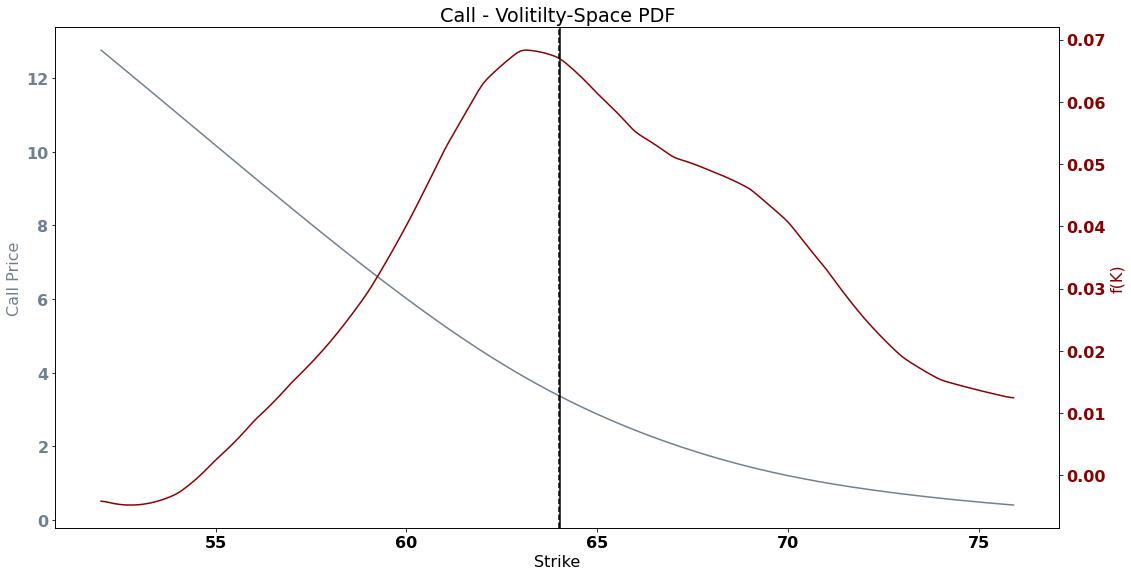

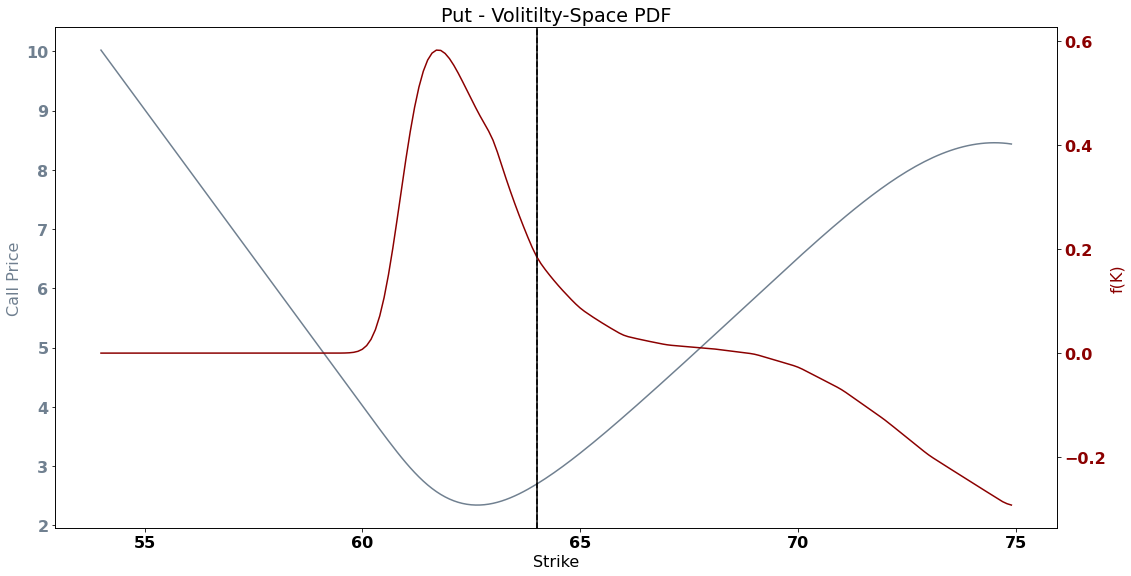

In [51]:
# Price of the underlying
S = 64.02

# Risk-free rate
r = 0

# Time till contract expiration
expiration_month = 3
expiration_year = 2023
t = get_t(expiration_month, expiration_year)

pdf = breeden_litzberger(data, S, t, r, plotfig=False, savefig=False)
pdf

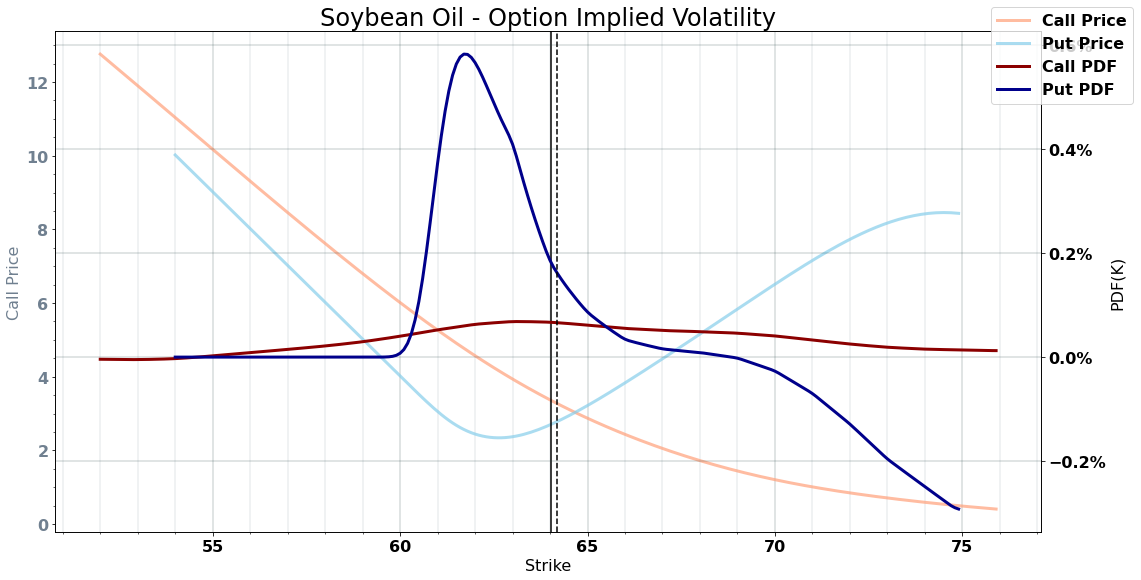

In [52]:
def plot_all(pdf, savefig=False):
    s = pdf.Strike.mean()
    c_pdf = pdf[pdf.Type == 'Call']
    p_pdf = pdf[pdf.Type == 'Put']
    c_pdf.reset_index(drop=True, inplace=True)
    p_pdf.reset_index(drop=True, inplace=True)

    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.rcParams.update({'font.size': 16, 'font.weight': 'bold'})
    fig, ax1 = plt.subplots(figsize=(16,8))
    # Plot Prices per Strike
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Call Price', color='slategrey')
    ax1.plot(c_pdf['Strike'], c_pdf['Price'], color="lightsalmon", alpha=.7, linewidth=3, label='Call Price')
    ax1.plot(p_pdf['Strike'], p_pdf['Price'], color="skyblue", alpha=.7, linewidth=3, label='Put Price')
    ax1.tick_params(axis='y', labelcolor='slategrey')
    ax1.axvline(S, color="k", linestyle="-")
    # Plot Probability per Strike
    ax2 = ax1.twinx()
    ax2.set_ylabel('PDF(K)')
    ax2.plot(c_pdf['Strike'], c_pdf['Prob'], color="darkred", linewidth=3, label='Call PDF')
    ax2.plot(p_pdf['Strike'], p_pdf['Prob'], color="darkblue", linewidth=3, label='Put PDF')
    ax2.tick_params(axis='y')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax2.axvline(s, color="k", linestyle="--")
    # Format Figure
    fig.legend()
    fig.tight_layout()
    ax1.set_xticks(ticks=c_pdf['Strike'].unique(), minor=True)
    ax1.minorticks_on()
    ax1.grid(axis='x', which='minor', linestyle='-', linewidth='0.2', color='slategray')
    ax1.grid(axis='x', which='major', linestyle='-', linewidth='0.3', color='darkslategray')
    ax2.grid(axis='y', which='major', linestyle='-', linewidth='0.3', color='darkslategrey')
    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax1.set_title(f'{commodity} - Option Implied Volatility',fontsize = 24)
    if savefig:
        plt.savefig("SBO_PDF_pt2.png", dpi=300)
    figure = plt.gcf()
    plt.show()
    return(figure)

fig = plot_all(pdf)


In [53]:
!datapane login --token=856743ad2e8cd913c6816ea39a222057b9da5d6e

Connected successfully to https://cloud.datapane.com as mac13faldet@gmail.com


In [54]:
import datapane as dp

app = dp.Report(                               # This initiates the report
    dp.Text(f"# {commodity} PDF"),             # Adding Text
    dp.Text("## Option Implied Probability - pt2"),
    dp.Text("""Probabilities calculated using Breeden-Litzberger option butterflys. Long two contracts of a Strike Price, short the strike +1 and -1."""),
    dp.Plot(fig),                           # Adding a Plot
    dp.Text(f"#### PDF of {commodity}"),
    dp.DataTable(pdf[['Strike','Type','Price','Prob']]))

app.upload(name=f"Report: {commodity} Options Implied PDF - pt2", open=True)
app.save("SBO_PDF_pt2.html")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\macfa\\AppData\\Local\\Temp\\dp-tmp-2dcp5ewi\\dp-tmp-eeb1o0go.svg'